In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split , Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image

from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class CnnAutoencoder(nn.Module):
    def __init__(self, input_channels=1, num_filters=(32, 64, 128), kernel_size=3, latent_dim=128,
                 learning_rate=0.001, optimizer_choice='adam'):
        super(CnnAutoencoder, self).__init__()

        self.learning_rate = learning_rate
        self.kernel_size = kernel_size
        self.num_filters = num_filters
        self.optimizer_choice = optimizer_choice
        self.latent_dim = latent_dim

        # Encoder
        encoder_layers = []
        in_channels = input_channels
        for out_channels in num_filters:
            encoder_layers.append(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=2, padding=kernel_size // 2)
            )
            encoder_layers.append(nn.ReLU())
            in_channels = out_channels
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder
        # Decoder
        decoder_layers = []
        for out_channels in reversed(num_filters):
            decoder_layers.append(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=2, padding=kernel_size // 2, output_padding=1)
            )
            decoder_layers.append(nn.ReLU())
            in_channels = out_channels

        # Update the last layer to use Tanh instead of Sigmoid
        decoder_layers.append(nn.ConvTranspose2d(in_channels, input_channels, kernel_size=kernel_size, stride=1, padding=kernel_size // 2))
        decoder_layers.append(nn.Tanh())  # Changed from Sigmoid to Tanh
        self.decoder = nn.Sequential(*decoder_layers)

        # decoder_layers = []
        # for out_channels in reversed(num_filters):
        #     decoder_layers.append(
        #         nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=2, padding=kernel_size // 2, output_padding=1)
        #     )
        #     decoder_layers.append(nn.ReLU())
        #     in_channels = out_channels
        # decoder_layers.append(nn.ConvTranspose2d(in_channels, input_channels, kernel_size=kernel_size, stride=1, padding=kernel_size // 2))
        # decoder_layers.append(nn.Sigmoid())
        # self.decoder = nn.Sequential(*decoder_layers)

        # Initialize optimizer based on optimizer_choice
        self.optimizer = self._initialize_optimizer()

    def _initialize_optimizer(self):
        if self.optimizer_choice.lower() == 'adam':
            return optim.Adam(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_choice.lower() == 'sgd':
            return optim.SGD(self.parameters(), lr=self.learning_rate)
        else:
            raise ValueError(f"Unsupported optimizer choice: {self.optimizer_choice}")

    def encode(self, x):
        x = self.encoder(x)
        self.encoded_shape = x.shape  # Store shape for decoding
        flattened_size = x.size(1) * x.size(2) * x.size(3)

        # Dynamically create fc_upsample with the correct size
        self.fc_upsample = nn.Linear(flattened_size, self.latent_dim).to(x.device)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layer
        x = self.fc_upsample(x)     # Compress to latent_dim
        return x

    def decode(self, x):
        # Define fc_downsample to expand from latent_dim back to flattened size
        if not hasattr(self, 'fc_downsample'):
            flattened_size = self.encoded_shape[1] * self.encoded_shape[2] * self.encoded_shape[3]
            self.fc_downsample = nn.Linear(self.latent_dim, flattened_size).to(x.device)

        x = self.fc_downsample(x)
        x = x.view(x.size(0), *self.encoded_shape[1:])  # Reshape to encoded shape
        x = self.decoder(x)
        return x

    def forward(self, x):
        latent = self.encode(x)
        reconstructed = self.decode(latent)
        return reconstructed


In [ ]:
class MLP_Autoencoder(nn.Module):
    def __init__(self, input_size=784, hidden_dims=[256, 128], latent_dim=32):
        super(MLP_Autoencoder, self).__init__()

        # Encoder
        encoder_layers = []
        in_dim = input_size
        for h_dim in hidden_dims:
            encoder_layers.append(nn.Linear(in_dim, h_dim))
            encoder_layers.append(nn.ReLU())
            in_dim = h_dim
        encoder_layers.append(nn.Linear(hidden_dims[-1], latent_dim))
        encoder_layers.append(nn.ReLU())

        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder
        decoder_layers = []
        in_dim = latent_dim
        for h_dim in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(in_dim, h_dim))
            decoder_layers.append(nn.ReLU())
            in_dim = h_dim
        decoder_layers.append(nn.Linear(hidden_dims[0], input_size))
        decoder_layers.append(nn.Sigmoid())  # to match the pixel range of (0, 1)

        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the images
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

class MLP_Classifier(nn.Module):
    def __init__(self, input_dim=32, hidden_dims=[128, 64], output_dim=10):
        super(MLP_Classifier, self).__init__()

        classifier_layers = []
        in_dim = input_dim
        for h_dim in hidden_dims:
            classifier_layers.append(nn.Linear(in_dim, h_dim))
            classifier_layers.append(nn.ReLU())
            in_dim = h_dim
        classifier_layers.append(nn.Linear(hidden_dims[-1], output_dim))

        self.classifier = nn.Sequential(*classifier_layers)

    def forward(self, x):
        return self.classifier(x)


In [ ]:
class PcaAutoencoder:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.pca = None

    def fit(self, X):
        """
        Fit the PCA model to the training data.
        """
        self.pca = PCA(n_components=self.n_components)
        self.pca.fit(X)

    def encode(self, X):
        """
        Encode data using the PCA model.
        """
        if self.pca is None:
            raise ValueError("The model has not been fitted yet. Call fit() first.")
        return self.pca.transform(X)

    def forward(self, X):
        """
        Reconstruct data from the encoded representation.
        """
        if self.pca is None:
            raise ValueError("The model has not been fitted yet. Call fit() first.")
        encoded = self.encode(X)
        return self.pca.inverse_transform(encoded)


In [ ]:
def extract_latent_features(autoencoder, data_loader, device):
    autoencoder.eval()  # Set to evaluation mode
    latent_features = []

    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            latent = autoencoder.encode(images)  # Obtain latent features
            latent = latent.view(images.size(0), -1)  # Flatten for KNN compatibility
            latent_features.append(latent.cpu().numpy())

    return np.vstack(latent_features)  # Combine all batches


In [ ]:
best_pca_autoencoder = PcaAutoencoder()  # Replace with the appropriate model class
best_pca_autoencoder.load_state_dict(torch.load('/content/best_pca_autoencoder.pth'))

best_cnn_autoencoder = CnnAutoencoder()  # Replace with the appropriate model class
best_cnn_autoencoder.load_state_dict(torch.load('/content/best_cnn_autoencoder.pth'))

best_mlp_autoencoder = MLP_Autoencoder()  # Replace with the appropriate model class
best_mlp_autoencoder.load_state_dict(torch.load('/content/best_mlp_autoencoder.pth'))

train_latent_pca = extract_latent_features(best_pca_autoencoder, train_loader, device)
test_latent_pca = extract_latent_features(best_pca_autoencoder, test_loader, device)

train_latent_cnn = extract_latent_features(best_cnn_autoencoder, train_loader, device)
test_latent_cnn = extract_latent_features(best_cnn_autoencoder, test_loader, device)

train_latent_mlp = extract_latent_features(best_mlp_autoencoder, train_loader, device)
test_latent_mlp = extract_latent_features(best_mlp_autoencoder, test_loader, device)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def train_and_evaluate_knn(train_features, train_labels, test_features, test_labels, k=5):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_features, train_labels)
    predictions = knn.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    return accuracy


In [1]:
accuracy_pca = train_and_evaluate_knn(train_latent_pca, train_labels, test_latent_pca, test_labels)
accuracy_cnn = train_and_evaluate_knn(train_latent_cnn, train_labels, test_latent_cnn, test_labels)
accuracy_mlp = train_and_evaluate_knn(train_latent_mlp, train_labels, test_latent_mlp, test_labels)

print(f"PCA Autoencoder KNN Accuracy: {accuracy_pca:.4f}")
print(f"CNN Autoencoder KNN Accuracy: {accuracy_cnn:.4f}")
print(f"MLP Autoencoder KNN Accuracy: {accuracy_mlp:.4f}")


NameError: name 'train_and_evaluate_knn' is not defined

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Assuming train/test latent features are obtained from each autoencoder
autoencoders = ['CNN','MLP', 'PCA']
test_accuracies = [accuracy_cnn,accuracy_mlp,accuracy_pca]

# for name, features in autoencoders.items():
#     # Train KNN on the training set latent features
#     knn = KNeighborsClassifier(n_neighbors=k_optimal)
#     knn.fit(features['train'], y_train)

#     # Predict and calculate accuracy for train and test
#     train_accuracy = accuracy_score(y_train, knn.predict(features['train']))
#     test_accuracy = accuracy_score(y_test, knn.predict(features['test']))

#     # Store accuracies
#     train_accuracies.append(train_accuracy)
#     test_accuracies.append(test_accuracy)

# # Plotting
labels = autoencoders
x = range(len(labels))

plt.figure(figsize=(10, 6))
# plt.bar(x, train_accuracies, width=0.4, label='Train Accuracy', color='blue', align='center')
plt.bar(x, test_accuracies, width=0.4, label='Test Accuracy', color='orange', align='edge')
plt.xlabel('Autoencoder Type')
plt.ylabel('Accuracy')
plt.title('KNN Classification Accuracies on Latent Features')
plt.xticks(x, labels)
plt.legend()
plt.show()

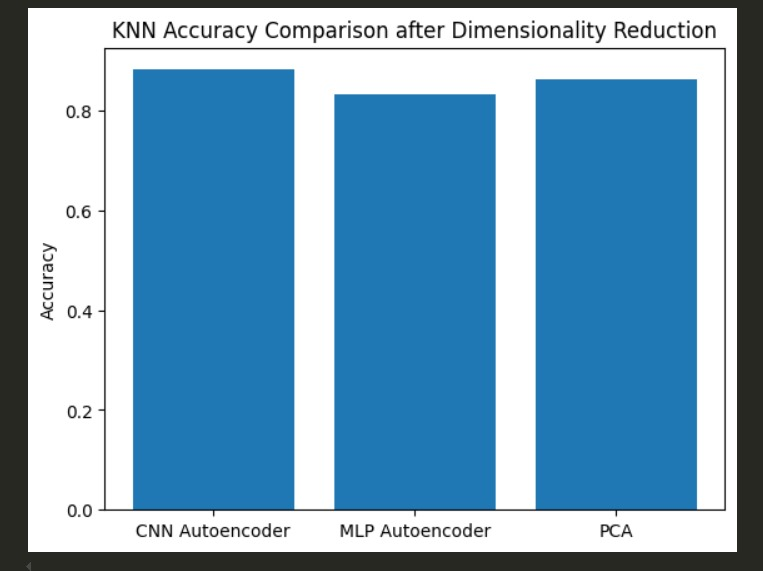

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

autoencoders = {'CNN': test_cnn_latent, 'MLP': test_mlp_latent, 'PCA': test_pca_latent}
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, (name, features) in enumerate(autoencoders.items()):
    # Predict on test set
    y_pred = knn.predict(features)

    # Compute confusion matrix
    cm = confusion_matrix(features, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {name} Autoencoder')
    axes[i].set_xlabel('Predicted Labels')
    axes[i].set_ylabel('True Labels')

plt.show()


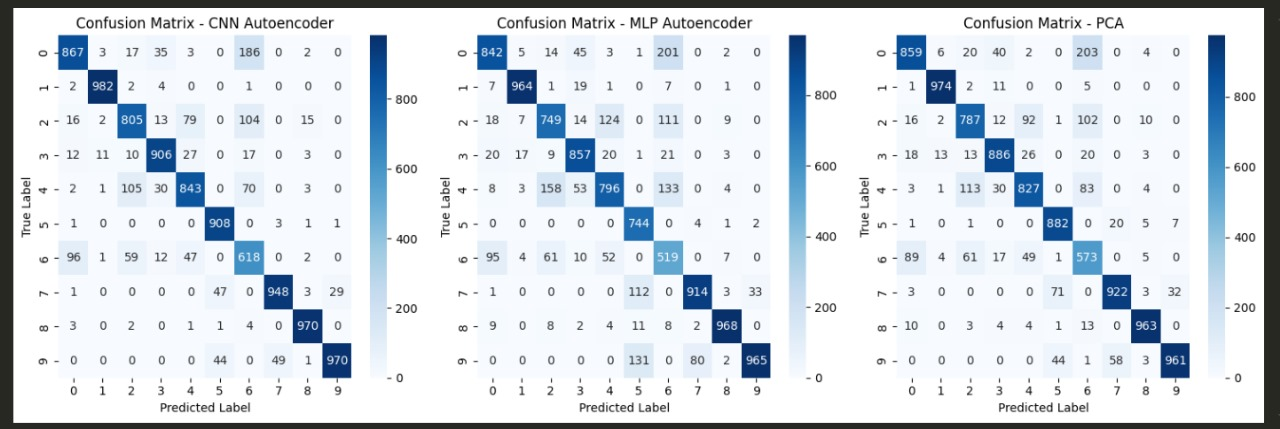

## Performance Across Models
- **CNN Autoencoder** shows strong performance with lower misclassification in most classes. It has clearer separation between classes, particularly noticeable with higher values along the diagonal.
- **MLP Autoencoder** has a slightly higher rate of misclassifications compared to CNN, especially for classes 2, 3, and 5, indicating that it struggles more with complex or overlapping features.
- **PCA Autoencoder** has the highest misclassification rate among the three, particularly in classes like 5 and 8. This suggests that PCA’s linear nature limits its ability to capture complex representations as effectively as CNN or MLP.